In [3]:
import pandas as pd
import numpy as np

from datetime import datetime
from datetime import timedelta

from scipy.optimize import curve_fit
from scipy.optimize import fsolve

import matplotlib.pyplot as plt

import re

In [4]:
pd.set_option('display.width', 1000)

In [5]:
url_cases = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'

df_load_cases = pd\
    .read_csv(url_cases, sep=',', engine='python')\
    .groupby("Country/Region")\
    .sum()\
    .reset_index(level=[0])\
    .rename({"Country/Region": 'countriesAndTerritories'}, axis='columns', inplace=False)\
    .drop(['Lat', 'Long'], axis='columns')\
    .melt('countriesAndTerritories', var_name='dateRep', value_name='cum_cases')

url_deaths = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'

df_load_deaths = pd\
    .read_csv(url_deaths, sep=',', engine='python')\
    .groupby("Country/Region")\
    .sum()\
    .reset_index(level=[0])\
    .rename({"Country/Region": 'countriesAndTerritories'}, axis='columns', inplace=False)\
    .drop(['Lat', 'Long'], axis='columns')\
    .melt('countriesAndTerritories', var_name='dateRep', value_name='cum_deaths')

df_load_jh = pd\
    .merge(df_load_cases, df_load_deaths,  how='inner', on=['countriesAndTerritories', 'dateRep'])

df_load_jh['dateRep'] = df_load_jh['dateRep'].map(lambda x : (datetime.strptime(x, '%m/%d/%y').strftime('%d/%m/%Y')))

df_1_jh = df_load_jh

df_1_jh['days'] = df_1_jh['dateRep']\
    .map(lambda x : (datetime.strptime(x, '%d/%m/%Y') - datetime.strptime("01/01/2020", '%d/%m/%Y')).days)

df_1_jh = df_1_jh.sort_values(['countriesAndTerritories', 'days'], ascending=[True, True])
df_1_jh = df_1_jh[df_1_jh['days'] >= 0]

df_2_jh = df_1_jh\
    .loc[:,['countriesAndTerritories', 'days', 'dateRep', 'cum_cases', 'cum_deaths']]

df_2_jh['source'] = 'jh'

Remarks: ECDC data does not match RKI data in all time points!

Unfortunately, at least for Germany (Robert Koch Institute (RKI) data), I have found some potential data issues. For some days the reported number of cases/deaths is different from RKI.

Some observations (ECDC v RKI):
* 1,042 incremental/8,198 cumulative ( 2020-03-19) vs 1,042/8,198 (2020-03-19)   (not okay, a shift in the day)
* 2020-03-20: 5,940/14,138 vs 2,958/13,957 (not okay)
* 2020-03-24: 4,438/29,212 vs 4,764/27,436 (not okay)
* 2020-03-25: 2,342/31,554 vs 4,118/31,554 (not okay, wrong increments)
* 2020-03-28: 6,294/48,582 vs 6,294/48,582 (okay)

I have used the following ECDC data:
[Link](https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide)

RKI data:
[Situationsbericht 2020-03-18](https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Situationsberichte/2020-03-18-de.pdf?__blob=publicationFile),
[Situationsbericht 2020-03-24](https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Situationsberichte/2020-03-24-de.pdf?__blob=publicationFile),
[Situationsbericht 2020-03-25](https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Situationsberichte/2020-03-25-de.pdf?__blob=publicationFile) and 
[Situationsbericht 2020-03-28](https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Situationsberichte/2020-03-28-de.pdf?__blob=publicationFile)


In [6]:
url = "https://opendata.ecdc.europa.eu/covid19/casedistribution/csv/"

df_load_ecdc = pd\
    .read_csv(url, sep=',', engine='python')

df_load_ecdc.columns= [re.sub("[^A-Za-z]", "", col) for col in df_load_ecdc.columns]

df_1_ecdc = df_load_ecdc\
    .loc[:,['dateRep','cases', 'deaths', 'countriesAndTerritories']]

df_1_ecdc['days'] = df_1_ecdc['dateRep']\
    .map(lambda x : (datetime.strptime(x, '%d/%m/%Y') - datetime.strptime("01/01/2020", '%d/%m/%Y')).days)

df_1_ecdc = df_1_ecdc.sort_values(['countriesAndTerritories', 'days'], ascending=[True, True])
df_1_ecdc = df_1_ecdc[df_1_ecdc['days'] >= 0]

df_2_ecdc =  df_1_ecdc\
    .groupby(['countriesAndTerritories', 'days','dateRep'])\
    .agg(cum_cases=('cases', 'sum'), cum_deaths=('deaths', 'sum'))\
    .groupby(level=[0])\
    .cumsum()\
    .reset_index(level=[0, 1, 2])

df_2_ecdc = df_2_ecdc.sort_values(['countriesAndTerritories', 'days'], ascending=[True, True])

df_2_ecdc['source'] = 'ecdc'

In [7]:
df_2 = pd.concat([df_2_jh, df_2_ecdc])

In [9]:
df_same_1 = df_2

df_same_2 = df_same_1[df_same_1['cum_cases'] >= 1000]\
    .groupby(['countriesAndTerritories', 'source'])\
    .agg(min_days=('days', 'min'))

df_3 = pd\
    .merge(df_2, df_same_2,  how='inner', on=['countriesAndTerritories', 'source'])

df_3['same_day'] = df_3['days'] - df_3['min_days']

df_3 = df_3.drop(['min_days'], axis='columns')

In [168]:
df_3 = df_3.sort_values(['countriesAndTerritories', 'days','dateRep', 'source'], ascending=[True, True, True, True])

df_3_inc = df_3\
    .groupby(['source', 'countriesAndTerritories', 'days','dateRep'])\
    .agg(cases=('cum_cases', 'sum'), deaths=('cum_deaths', 'sum'))\
    .groupby(level=[0])\
    .diff(periods=1, axis=0)\
    .reset_index(level=[0, 1, 2, 3])

df_4 = pd.merge(df_3, df_3_inc,  how='inner', on=['countriesAndTerritories', 'days','dateRep', 'source'])

df_4['cases'] = df_4['cases'].fillna(df_4['cum_cases'])
df_4['deaths'] = df_4['deaths'].fillna(df_4['cum_deaths'])

In [172]:
df_final = df_4

In [173]:
#df_4[(df_4['countriesAndTerritories'] == "Germany") & (df_4['days'] > 70) & (df_4['source'] == 'jh')]

In [174]:
df_countries = df_final[df_final['source'] == 'jh']\
    .groupby(['countriesAndTerritories'])\
    .agg(cum_cases=('cum_cases', 'max'))\
    .sort_values(['cum_cases'], ascending=[False])\
    .reset_index(level=[0])

list_countries = df_countries.iloc[:9]['countriesAndTerritories'].tolist()

In [175]:
def plot_total(df, country, ax, quantity_axis='cum_cases', days_axis='days', limit=None, source='jh'):
    df = df[df['countriesAndTerritories'] == country]
    df = df[df['source'] == source]
    df = df[df[quantity_axis] > 0]
    df = df[df[days_axis] > 0]
    
    if limit != None:
        df = df[df[days_axis] < limit]
    
    df.plot(x=days_axis, y=quantity_axis, ax=ax, label=country, alpha=0.5)

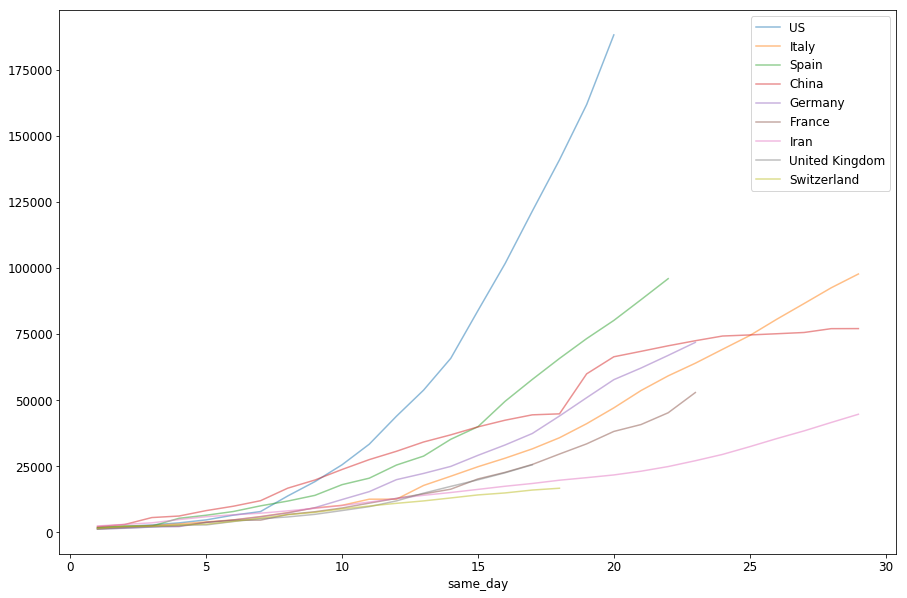

In [176]:
fig, axs = plt.subplots(1, 1)
for country in list_countries:
    plot_total(df_final, country, axs, 'cum_cases', 'same_day', 30, 'jh')

In [177]:
def plot_country(df, country, ax, source):
    df = df[df['countriesAndTerritories'] == country]
    df = df[df['source'] == source]
    df = df[df['cum_cases'] > 100]
    
    x = list(df['days'])
    y_cases = list(df['cum_cases'])
    y_deaths = list(df['cum_deaths'])
       
    ax.plot(x, y_cases, label="cases", color="steelblue")
    ax.plot(x, y_deaths, label="deaths", color="orange")
    ax.set_title(country)
    
    ax.fill_between(x, y_deaths, y_cases, alpha=0.5, color="steelblue")
    ax.fill_between(x, 0, y_deaths, alpha=0.5, color="orange")
    
    ax.set_xlabel("Days since 1 January 2020")
    ax.set_ylabel("Cumulated numbers")

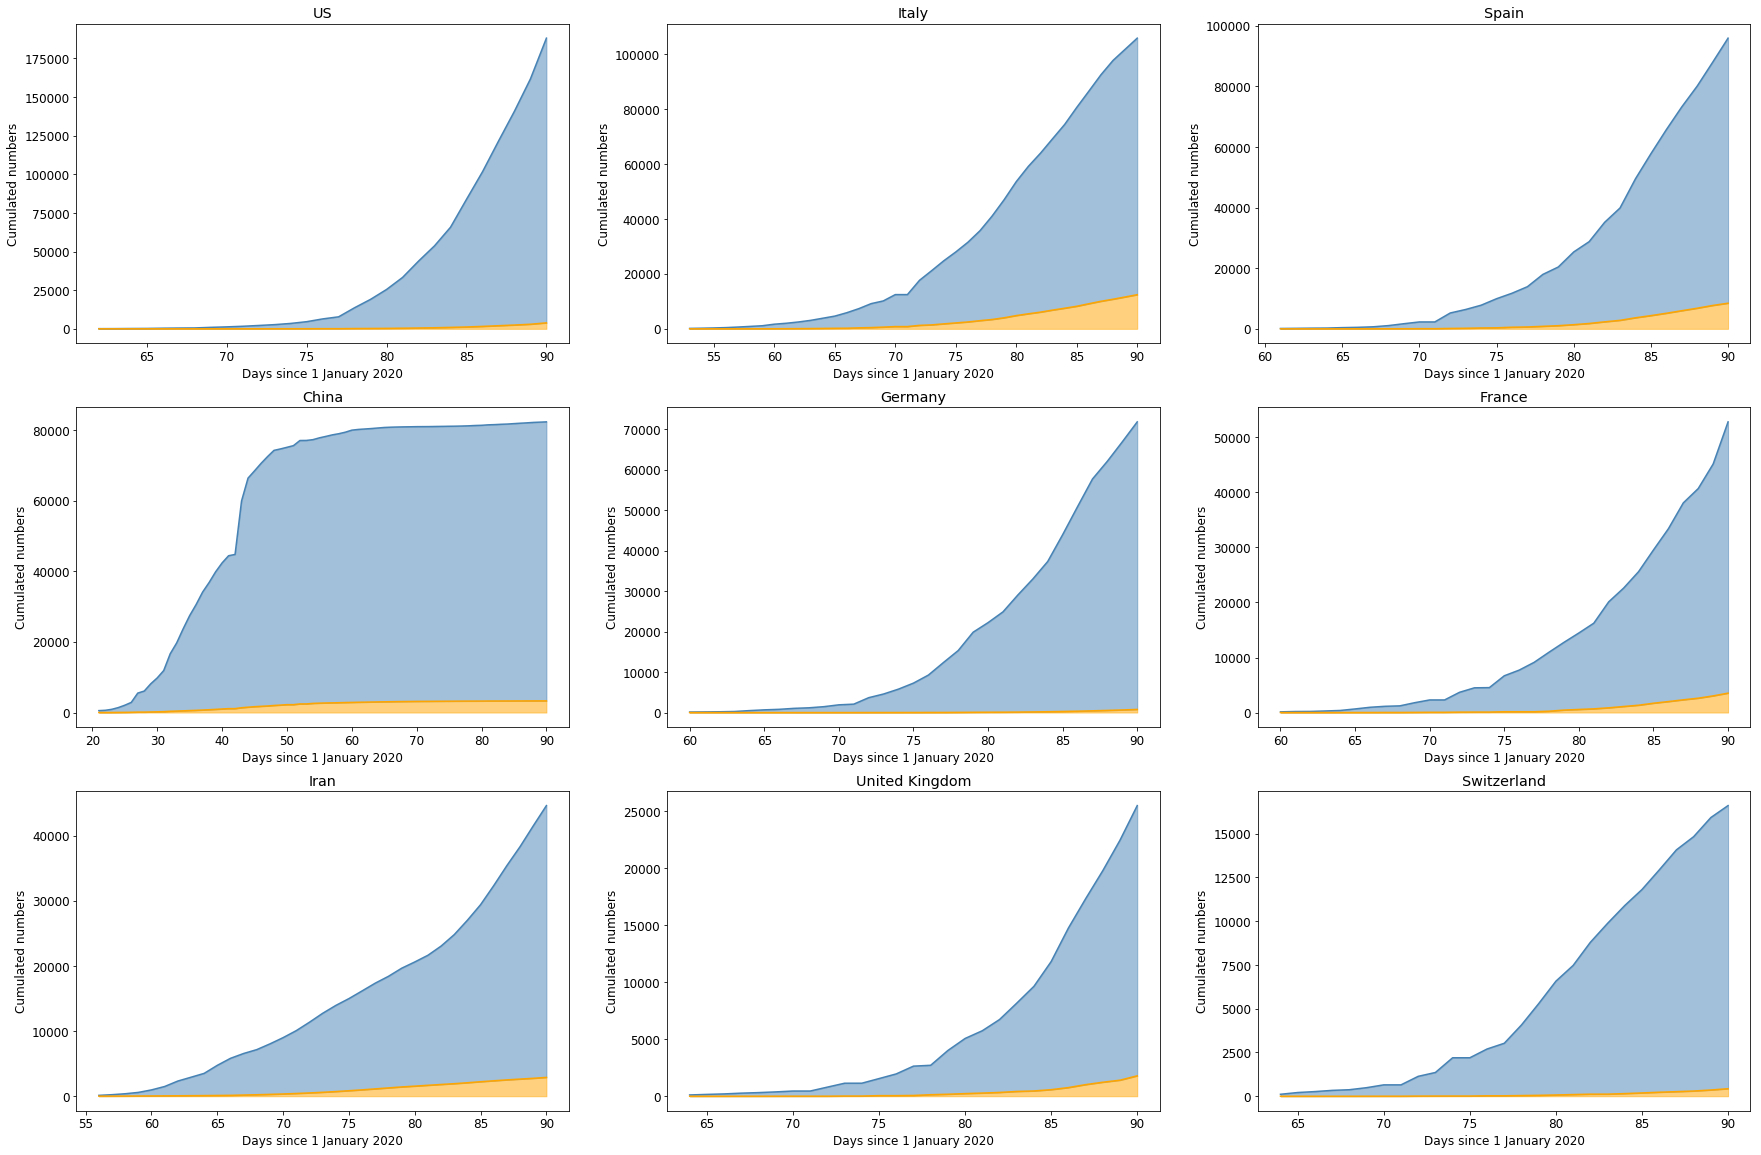

In [178]:
fig, axs = plt.subplots(3, 3, figsize=(30,20))
for country, ax in zip(list_countries, axs.ravel()):
    plot_country(df_final, country, ax, source='jh')

In [179]:
def logistic_model(x, a, b, c):
    return c/(1 + np.exp(-(x - b)/a))

def exponential_2p_model(x, a, b):
    return a*np.exp(b*x)

def fitting(model, x, y):
    if model == 'logistic':
        fit = curve_fit(logistic_model, x, y, p0=[2, 100, 20000], maxfev = 50000)
        return fit
    if model == 'exponential':
        fit = curve_fit(exponential_2p_model, x, y, p0=[10000, 0.1], maxfev = 50000)
        return fit

def model_selection(model):
    if model == 'logistic':
        return logistic_model
    if model == 'exponential':
        return exponential_2p_model
    
def additional_info(model, fit):
    if model == 'logistic':
        print('days to reach limit of ', "{:,}".format(int(fit[0][2])) , ': ', "{:,}".format(int(int(fsolve(lambda x : logistic_model(x, *fit[0]) - int(fit[0][2]), fit[0][1])))))
    if model == 'exponential':
        print('time to double:', np.round(np.log(2)/fit[0][1], 1))

In [180]:
def extrapolate(x, y_cases, model, days_fitting, days_extropolate, shift, plot_actuals, plot_curve, ann_pos, ann, cum):

    x_fit = x[-days_fitting - shift:-shift or None]
    y_cases_fit = y_cases[-days_fitting - shift:-shift or None]
    
    if cum:
        if plot_actuals:
            plt.scatter(x_fit, y_cases_fit, label="real data", color="red")
    else:
        if plot_actuals:
            plt.scatter(x_fit[1:], np.diff(y_cases_fit).tolist(), label="real data", color="red")

    selected_model = model_selection(model)
    fit = fitting(model, x_fit, y_cases_fit)

    x_pred = list(range(max(x_fit) + 1, max(x_fit) + days_extropolate + shift + 1))
    y_pred = [int(selected_model(i, *fit[0])) for i in x_pred]
    
    if cum:
        x_pred_plot = x_pred
        y_pred_plot = y_pred
    else:
        x_pred_plot = x_pred[1:]
        y_pred_plot = np.diff(y_pred).tolist()
        
    plt.scatter(x_pred_plot, y_pred_plot, color="gold")
    
    if ann:
        for i,j in zip(x_pred_plot, y_pred_plot):
            plt.annotate("{:,}".format(int(j)), xy=(i, j), horizontalalignment=ann_pos, verticalalignment='top')

    if plot_curve:
        x_tot = x_fit + x_pred
        y_tot = [selected_model(i, *fit[0]) for i in x_tot]
        
        if not cum:
            x_tot = x_tot[1:]
            y_tot = np.diff(y_tot).tolist()
        
        plt.plot(x_tot, y_tot, label=model + " " + str(shift) + " days prior last acutal", color="steelblue", linestyle='dashed')
    
    return x_pred, y_pred, fit

In [181]:
def collect_dict(x_data, y_data):
    
    dict_data = {}

    for x_i, y_i in zip(x_data, y_data):
        dict_data[
            (datetime.strptime("01/01/2020", '%d/%m/%Y') + timedelta(days=x_i)).strftime('%d/%m/%Y')
        ] = "{:,}".format(int(y_i))

    return dict_data

In [182]:
def single_country(model, country, df_input, days_fitting=14, days_extropolate=3, cum=True):
    df_select = df_input[df_input['countriesAndTerritories'] == country]
    df_select  = df_select[df_select['cum_cases'] > 100]
    
    x = list(df_select['days'])
    y_cases = list(df_select['cum_cases'])
    y_deaths = list(df_select['cum_deaths'])

    plt.rcParams["figure.figsize"] = (15,10)
    plt.rcParams["font.size"] = 12

    ax = plt.axes()
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    
    if cum:
        plt.plot(x, y_cases, label="cases", color="steelblue")
        plt.plot(x, y_deaths, label="deaths", color="orange")
        plt.title(country + " - " + model.capitalize())

        plt.fill_between(x, y_deaths, y_cases, alpha=0.5, color="steelblue")
        plt.fill_between(x, 0, y_deaths, alpha=0.5, color="orange")

        plt.xlabel("Days since 1 January 2020")
        plt.ylabel("Cumulated numbers")
    else:
        plt.plot(x[1:], np.diff(y_cases).tolist(), label="cases", color="steelblue")
        plt.plot(x[1:], np.diff(y_deaths).tolist(), label="deaths", color="orange")
        plt.title(country + " - " + model.capitalize())

        plt.xlabel("Days since 1 January 2020")
        plt.ylabel("Incremental numbers")

    x_pred, y_pred, fit_pred = extrapolate(
        x,
        y_cases,
        model,
        days_fitting=days_fitting,
        days_extropolate=days_extropolate,
        shift=0,
        plot_actuals=True,
        plot_curve=True,
        ann_pos='left',
        ann=False,
        cum=cum
    )

    x_pred_prior, y_pred_prior, fit_pred_prior = extrapolate(
        x,
        y_cases,
        model,
        days_fitting=days_fitting,
        days_extropolate=days_extropolate,
        shift=7,
        plot_actuals=False,
        plot_curve=True,
        ann_pos='right',
        ann=False,
        cum=cum
    )
    
    print('Predic:')
    additional_info(model, fit_pred)
    print(collect_dict(x[-3:] + x_pred[-2:], y_cases[-3:] + y_pred[-2:]))
    print('Predic Prior:')
    print(collect_dict(x_pred_prior[-5:], y_pred_prior[-5:]))

    plt.legend()
    plt.show()

In [183]:
print(*[(i, country) for i, country in enumerate(list_countries)], sep='\n')

(0, 'US')
(1, 'Italy')
(2, 'Spain')
(3, 'China')
(4, 'Germany')
(5, 'France')
(6, 'Iran')
(7, 'United Kingdom')
(8, 'Switzerland')


    dateRep  cum_cases  cum_deaths
 18/03/2020      12327          28
 19/03/2020      15320          44
 20/03/2020      19848          67
 21/03/2020      22213          84
 22/03/2020      24873          94
 23/03/2020      29056         123
 24/03/2020      32986         157
 25/03/2020      37323         206
 26/03/2020      43938         267
 27/03/2020      50871         342
 28/03/2020      57695         433
 29/03/2020      62095         533
 30/03/2020      66885         645
 31/03/2020      71808         775

Predic:
days to reach limit of  113,105 :  145
{'29/03/2020': '62,095', '30/03/2020': '66,885', '31/03/2020': '71,808', '02/04/2020': '82,480', '03/04/2020': '86,810'}
Predic Prior:
{'30/03/2020': '43,772', '31/03/2020': '44,530', '01/04/2020': '45,104', '02/04/2020': '45,534', '03/04/2020': '45,856'}


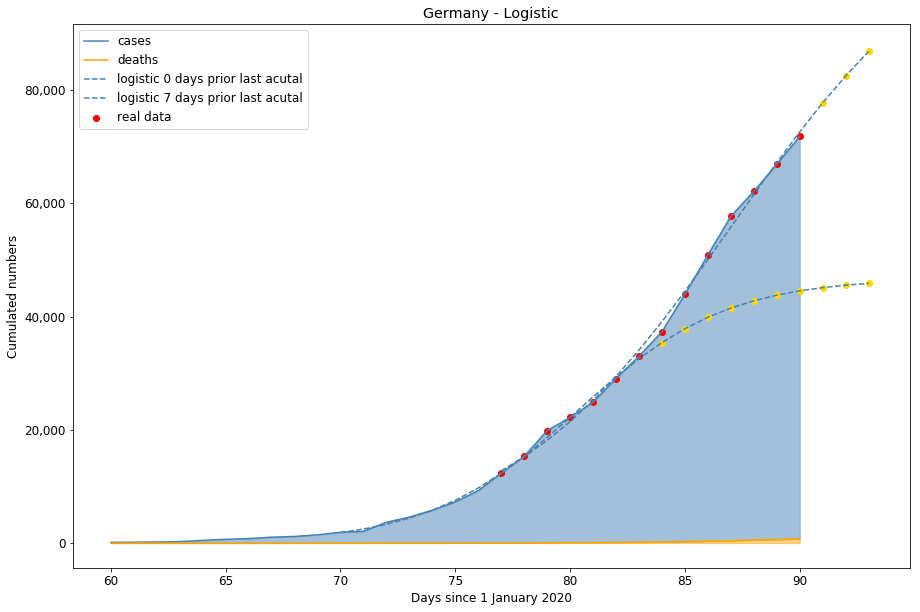

Predic:
days to reach limit of  113,105 :  145
{'29/03/2020': '62,095', '30/03/2020': '66,885', '31/03/2020': '71,808', '02/04/2020': '82,480', '03/04/2020': '86,810'}
Predic Prior:
{'30/03/2020': '43,772', '31/03/2020': '44,530', '01/04/2020': '45,104', '02/04/2020': '45,534', '03/04/2020': '45,856'}


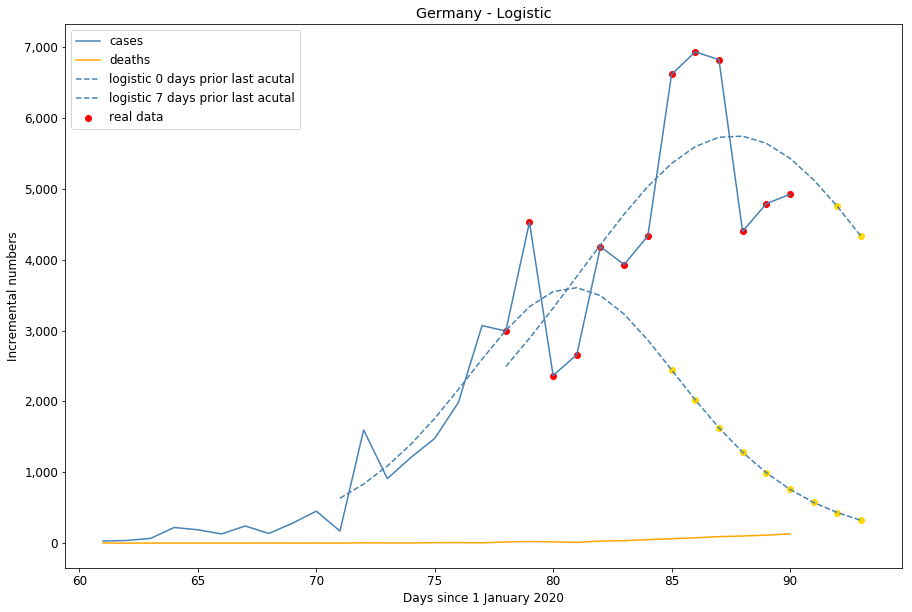

In [184]:
country = list_countries[4]
days_fitting = 14
days_extropolate = 3
source = 'jh'
# source = 'ecdc'
model = 'logistic'
# model = 'exponential'

df_select = df_final[df_final['countriesAndTerritories'] == country]
df_select  = df_select[df_select['cum_cases'] > 100]
df_select  = df_select[df_select['source'] == source]

print(df_select.loc[:, ['dateRep', 'cum_cases', 'cum_deaths']][-14:].to_string(index=False))
print('')

single_country(
    model='logistic',
    country=country,
    df_input=df_select,
    days_fitting=days_fitting,
    days_extropolate=days_extropolate,
    cum=True
)

single_country(
    model='logistic',
    country=country,
    df_input=df_select,
    days_fitting=days_fitting,
    days_extropolate=days_extropolate,
    cum=False
)

In [239]:
import pandas as pd
from bokeh.palettes import Spectral11
from bokeh.plotting import figure
from bokeh.io import output_notebook, push_notebook, show , output_file
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.models import NumeralTickFormatter, DatetimeTickFormatter

output_notebook(hide_banner=True)

In [252]:
def single_country_new(model, country, source, what, df_input, days_fitting=14, days_extropolate=3, cum=True):
    
    df_input = df_input[df_input['countriesAndTerritories'] == country]
    df_input= df_input[df_input['cum_cases'] > 100]
    df_input = df_input[df_input['source'] == source]
    
    df_input['date'] = df_input['dateRep']\
        .map(lambda x : datetime.strptime(x, '%d/%m/%Y'))
    
    p = figure(
        title=country + " - " + model.capitalize(),
        width=800,
        height=600,
        x_axis_type="datetime",
        toolbar_location="below"
    )
    
    p.xaxis.axis_label = 'days'
    p.yaxis.axis_label = 'cases'
    
#     p.extra_y_ranges = {"incremental": Range1d(start=0, end=35)}
    
    p.yaxis.formatter=NumeralTickFormatter(format="0,0")
    p.xaxis.formatter=DatetimeTickFormatter(
        years=["%d %m %Y"],
    )
    
    source = ColumnDataSource(
        data={
            'x': df_input['date'],
            'cases': df_input['cases'],
            'cum_cases': df_input['cum_cases'],
        }
    )   

    p.line(
        'x',
        'cases',
        source=source, 
        line_width=2,
        legend="reported cases",
        color="steelblue",
        alpha=0.5,
        hover_line_alpha=1
    )

    p.line(
        'x',
        'cum_cases',
        source=source, 
        line_width=2,
        legend="reported cases",
        color="steelblue",
        alpha=0.5,
        hover_line_alpha=1
    )
    
    p.add_tools(
        HoverTool(
            show_arrow=False,
            line_policy='nearest',
            tooltips=[
                ("date", "$x{%F}"),
                ('inc. cases', "@cases{0,0}"),
                ('cum. cases', "@cum_cases{0,0}")
            ],
            formatters={
                '$x': 'datetime',
            },
            mode='vline'
        )
    )
    
    show(p)
    
#     if cum:
#         plt.plot(x, y_cases, label="cases", color="steelblue")
#         plt.plot(x, y_deaths, label="deaths", color="orange")
#         plt.title(country + " - " + model.capitalize())

#         plt.fill_between(x, y_deaths, y_cases, alpha=0.5, color="steelblue")
#         plt.fill_between(x, 0, y_deaths, alpha=0.5, color="orange")

#         plt.xlabel("Days since 1 January 2020")
#         plt.ylabel("Cumulated numbers")
#     else:
#         plt.plot(x[1:], np.diff(y_cases).tolist(), label="cases", color="steelblue")
#         plt.plot(x[1:], np.diff(y_deaths).tolist(), label="deaths", color="orange")
#         plt.title(country + " - " + model.capitalize())

#         plt.xlabel("Days since 1 January 2020")
#         plt.ylabel("Incremental numbers")

#     x_pred, y_pred, fit_pred = extrapolate(
#         x,
#         y_cases,
#         model,
#         days_fitting=days_fitting,
#         days_extropolate=days_extropolate,
#         shift=0,
#         plot_actuals=True,
#         plot_curve=True,
#         ann_pos='left',
#         ann=False,
#         cum=cum
#     )

#     x_pred_prior, y_pred_prior, fit_pred_prior = extrapolate(
#         x,
#         y_cases,
#         model,
#         days_fitting=days_fitting,
#         days_extropolate=days_extropolate,
#         shift=7,
#         plot_actuals=False,
#         plot_curve=True,
#         ann_pos='right',
#         ann=False,
#         cum=cum
#     )
    
#     print('Predic:')
#     additional_info(model, fit_pred)
#     print(collect_dict(x[-3:] + x_pred[-2:], y_cases[-3:] + y_pred[-2:]))
#     print('Predic Prior:')
#     print(collect_dict(x_pred_prior[-5:], y_pred_prior[-5:]))

#     plt.legend()
#     plt.show()

In [253]:
country = list_countries[4]
days_fitting = 14
days_extropolate = 3
source = 'jh'
# source = 'ecdc'
model = 'logistic'
# model = 'exponential'
what = 'cases'
# what = 'death'

single_country_new(
    model=model,
    country=country,
    source=source,
    what=what,
    df_input=df_select,
    days_fitting=days_fitting,
    days_extropolate=days_extropolate,
    cum=True
)